In [40]:
import netCDF4
import pickle, pprint
import math
import netCDF4
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
import pandas as pd
import xarray as xr
import dask
from tabulate import tabulate
import scipy
from mpl_toolkits.basemap import Basemap
bm = Basemap() 

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  app.launch_new_instance()


In [18]:
path_to_file = '/fast/gmooers/Preprocessed_Data/7_Years_Spaced/full_physics_essentials_valid_month02_targets.nc'
real_ds = xr.open_dataset(path_to_file)

path_to_file = '/fast/gmooers/Models/Jordan_Best.nc'
predict_ds = xr.open_dataset(path_to_file)

path_to_file = '/fast/gmooers/Models/CAM_PRECIP_Annual_rcat.nc'
cam_ds = xr.open_dataset(path_to_file)

In [19]:
precip_real_ds = real_ds.targets[:, -1].values

precip_test_ds = predict_ds.Prediction[:, -1].values

precip_cam_ds = (cam_ds.PRECT.values)*86400000.

times = real_ds.time.values

lats = np.linspace(-90.0, 90.0, 96)
lons = np.linspace(0.0, 357.5, 144)

Xvar, Yvar = np.meshgrid(lons, lats)

x = 144
y = 96
z = 30
t = int(len(precip_real_ds)/(x*y))
print(t)

3420


In [20]:
reconstructed_targets = np.zeros(shape=(t, y, x))
reconstructed_DNN = np.zeros(shape=(t, y, x))

In [21]:
count = 0
for i in range(t):
    for j in range(y):
        for k in range(x):
            A = precip_test_ds[count]
            B = precip_real_ds[count]
            reconstructed_DNN[i, j, k] = A*86400000.
            reconstructed_targets[i, j, k] = B*86400000.
            count = count + 1
                
print(reconstructed_targets.shape)

(3420, 96, 144)


In [23]:
D = reconstructed_DNN.ravel()
T = reconstructed_targets.ravel()
C = precip_cam_ds.ravel()

In [24]:
max_values = [np.nanmax(D), np.nanmax(T), np.nanmax(C)]
min_values = [np.nanmin(D),  np.nanmin(T),  np.nanmin(C)]
m = min(min_values)
M = max(max_values)

In [25]:
#np.save("/fast/gmooers/RG_Paper_Data/SPCAM5_Precip_Prediction.npy",D)
#np.save("/fast/gmooers/RG_Paper_Data/SPCAM5_Prepip_Truth.npy",T)
#np.save("/fast/gmooers/RG_Paper_Data/CAM5_PRECIP.npy",C)
#np.save("/fast/gmooers/RG_Paper_Data/Precip_Max_Scalar.npy",m)
#np.save("/fast/gmooers/RG_Paper_Data/Precip_Min_Scalar.npy",M)

precip data saved - nothing else matters


In [27]:
ocean_DNN = np.zeros(shape=(t, y, x))
ocean_SPCAM5 = np.zeros(shape=(t, y, x))
ocean_CAM5 = np.zeros(shape=(len(precip_cam_ds),y, x))

ocean_DNN[:,:,:] = np.nan
ocean_SPCAM5[:,:,:] = np.nan
ocean_CAM5[:,:,:] = np.nan


for i in range(len(ocean_DNN[0][0])):
    lon = lons[i]
    if lon > 180.0:
        lon = lon - 360.0
    for j in range(len(ocean_DNN[i])):
        lat = lats[j]
        if bm.is_land(lon, lat) == False:
            ocean_DNN[:, j, i] = reconstructed_DNN[:, j, i]
            ocean_SPCAM5[:, j, i] = reconstructed_targets[:, j, i]
            
for i in range(len(ocean_CAM5[0][0])):
    lon = lons[i]
    if lon > 180.0:
        lon = lon - 360.0
    for j in range(len(ocean_CAM5[i])):
        lat = lats[j]
        if bm.is_land(lon, lat) == False:
            ocean_CAM5[:, j, i] = precip_cam_ds[:, j, i]
        

print('land masks applied')

land masks applied


In [28]:
land_DNN = np.zeros(shape=(t, y, x))
land_SPCAM5 = np.zeros(shape=(t, y, x))
land_CAM5 = np.zeros(shape=(len(precip_cam_ds),y, x))

land_DNN[:,:,:] = np.nan
land_SPCAM5[:,:,:] = np.nan
land_CAM5[:,:,:] = np.nan


for i in range(len(land_DNN[0][0])):
    lon = lons[i]
    if lon > 180.0:
        lon = lon - 360.0
    for j in range(len(land_DNN[i])):
        lat = lats[j]
        if bm.is_land(lon, lat) == True:
            land_DNN[:, j, i] = reconstructed_DNN[:, j, i]
            land_SPCAM5[:, j, i] = reconstructed_targets[:, j, i]
            
for i in range(len(land_CAM5[0][0])):
    lon = lons[i]
    if lon > 180.0:
        lon = lon - 360.0
    for j in range(len(land_CAM5[i])):
        lat = lats[j]
        if bm.is_land(lon, lat) == True:
            land_CAM5[:, j, i] = precip_cam_ds[:, j, i]
        

print('land masks applied')

land masks applied


In [29]:
ocean_CAM5 = ocean_CAM5[np.logical_not(np.isnan(ocean_CAM5))]
land_CAM5 = land_CAM5[np.logical_not(np.isnan(land_CAM5))]

ocean_SPCAM5 = ocean_SPCAM5[np.logical_not(np.isnan(ocean_SPCAM5))]
land_SPCAM5 = land_SPCAM5[np.logical_not(np.isnan(land_SPCAM5))]

ocean_DNN = ocean_DNN[np.logical_not(np.isnan(ocean_DNN))]
land_DNN = land_DNN[np.logical_not(np.isnan(land_DNN))]

In [30]:
C_ocean = ocean_CAM5.ravel()
C_land = land_CAM5.ravel()

D_ocean = ocean_DNN.ravel()
D_land = land_DNN.ravel()

T_ocean = ocean_SPCAM5.ravel()
T_land = land_SPCAM5.ravel()

In [32]:
ocean_max_values = [np.nanmax(D_ocean), np.nanmax(T_ocean), np.nanmax(C_ocean)]
ocean_min_values = [np.nanmin(D_ocean),  np.nanmin(T_ocean),  np.nanmin(C_ocean)]
m_ocean = min(ocean_min_values)
M_ocean = max(ocean_max_values)
land_max_values = [np.nanmax(D_land), np.nanmax(T_land), np.nanmax(C_land)]
land_min_values = [np.nanmin(D_land),  np.nanmin(T_land),  np.nanmin(C_land)]
m_land = min(land_min_values)
M_land = max(land_max_values)

In [33]:
#np.save("/fast/gmooers/RG_Paper_Data/Ocean_SPCAM5_Precip_Prediction.npy",D_ocean)
#np.save("/fast/gmooers/RG_Paper_Data/Ocean_SPCAM5_Prepip_Truth.npy",T_ocean)
#np.save("/fast/gmooers/RG_Paper_Data/Ocean_CAM5_PRECIP.npy",C_ocean)
#np.save("/fast/gmooers/RG_Paper_Data/Ocean_Precip_Max_Scalar.npy",m_ocean)
#np.save("/fast/gmooers/RG_Paper_Data/Ocean_Precip_Min_Scalar.npy",M_ocean)

#np.save("/fast/gmooers/RG_Paper_Data/Land_SPCAM5_Precip_Prediction.npy",D_land)
#np.save("/fast/gmooers/RG_Paper_Data/Land_SPCAM5_Prepip_Truth.npy",T_land)
#np.save("/fast/gmooers/RG_Paper_Data/Land_CAM5_PRECIP.npy",C_land)
#np.save("/fast/gmooers/RG_Paper_Data/Land_Precip_Max_Scalar.npy",m_land)
#np.save("/fast/gmooers/RG_Paper_Data/Land_Precip_Min_Scalar.npy",M_land)


print("precip data saved")

precip data saved - nothing else matters


In [35]:
def array_generator(min_val, max_val, percentage):
    listing = []
    for i in range(300):
        if i == 0:
            temp_val = min_val
            listing.append(temp_val)
        else:
            if temp_val < max_val:
                temp_val = temp_val*percentage
                listing.append(temp_val)
        
    print(len(listing))
    return np.array(listing)
#array_generator(0.03, maxi, 1.07)

In [42]:
fz = 15*1.5
lw = 4
siz = 100
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YTEXT = 0.3 # Text placement

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
matplotlib.rcParams['lines.linewidth'] = lw

In [48]:
print(C == C_ocean)
print(T == T_ocean)

False
False


/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


300


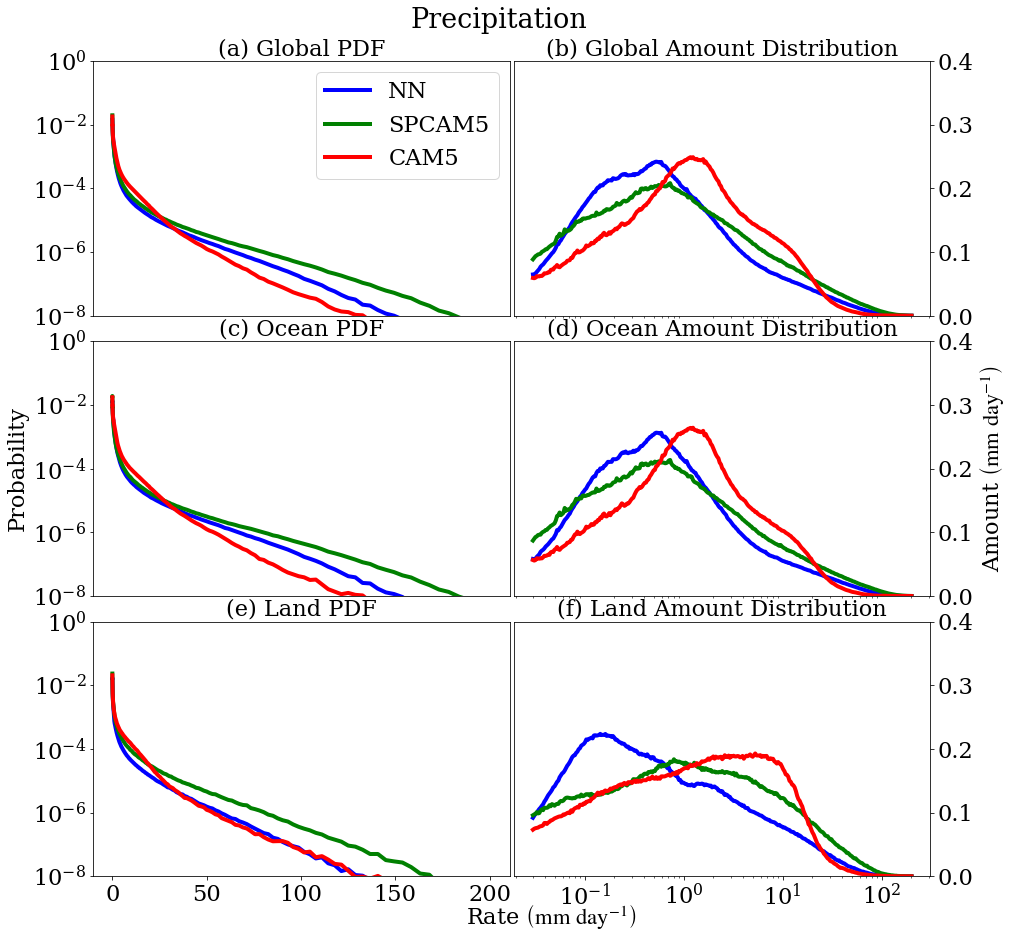

In [46]:
bins = array_generator(0.03, M, 1.03)



fig, ax = plt.subplots(3,2,figsize=(15,15))

shared_bins = np.histogram_bin_edges(D, bins=bins, range=(0, M))
freq, edges = np.histogram(D, bins = shared_bins, density=True)
#bad_freq, bad_edges = np.histogram(bad_feat, bins = shared_bins, density=True)
freq_targ, edges_targ = np.histogram(T, bins = shared_bins, density=True)
freq_cams, edges_cams = np.histogram(C, bins = shared_bins, density=True)

ax[0,1].set_xscale("log")
ax[1,1].set_xscale("log")
ax[2,1].set_xscale("log")

ax[0,0].plot(edges[:-1], freq/np.sum(freq),  label = "NN", color = 'blue')
#ax[0,0].plot(bad_edges[:-1], bad_freq/np.sum(bad_freq),  label = "Primative NN", color = 'blue', linestyle="--")
ax[0,0].plot(edges_targ[:-1], freq_targ/np.sum(freq_targ), label = "SPCAM5", color = 'green')
ax[0,0].plot(edges_cams[:-1], freq_cams/np.sum(freq_cams), label = "CAM5", color = 'red')
ax[0,0].set_ylim(1e-8, 1)

ax[2,0].set_xlabel('Rate '+r'$\left(\mathrm{mm \ day^{-1}}\right)$', fontsize = fz)
ax[2,0].xaxis.set_label_coords(1.1,-0.1)
ax[1,0].set_ylabel('Probability', fontsize = fz)
ax[0,0].set_title('(a) Global PDF', fontsize = fz)
ax[1,0].set_title('(c) Ocean PDF', fontsize = fz)
ax[2,0].set_title('(e) Land PDF', fontsize = fz)
ax[0,0].set_yscale('log')
ax[0,0].set_xticks([])
    
totals = freq*edges[:-1]
#bad_totals = bad_freq*bad_edges[:-1]
totals_targ = freq_targ*edges_targ[:-1]
totals_cam = freq_cams*edges_cams[:-1]
    
ax[0,1].plot(edges[:-1], totals,  label = "DNN", color = 'blue')
#ax[0,1].plot(bad_edges[:-1], bad_totals,  label = "Primative DNN", color = 'blue', linestyle="--")
ax[0,1].plot(edges_targ[:-1], totals_targ, label = "SPCAM5", color = 'green')
ax[0,1].plot(edges_cams[:-1], totals_cam, label = "CAM5", color = 'red')

ax[1,1].set_ylabel('Amount '+r'$\left(\mathrm{mm \ day^{-1}}\right)$', fontsize = fz)
ax[0,1].set_title('(b) Global Amount Distribution', fontsize = fz)
ax[1,1].set_title('(d) Ocean Amount Distribution', fontsize = fz)
ax[2,1].set_title('(f) Land Amount Distribution', fontsize = fz)
ax[0,0].legend(loc = 'best')

ax[0,1].yaxis.set_label_position("right")
ax[0,1].yaxis.tick_right()
ax[0,1].set_xticks([])
ax[0,1].set_ylim(0, 0.4)

shared_bins = np.histogram_bin_edges(D_ocean, bins=bins, range=(0, M))
freq, edges = np.histogram(D_ocean, bins = shared_bins, density=True)
#bad_freq, bad_edges = np.histogram(bad_ocean_feat, bins = shared_bins, density=True)
freq_targ, edges_targ = np.histogram(T_ocean, bins = shared_bins, density=True)
freq_cams, edges_cams = np.histogram(C_ocean, bins = shared_bins, density=True)

ax[1,0].plot(edges[:-1], freq/np.sum(freq), color = 'blue')
#ax[1,0].plot(bad_edges[:-1], bad_freq/np.sum(bad_freq), color = 'blue', linestyle="--")
ax[1,0].plot(edges_targ[:-1], freq_targ/np.sum(freq_targ), color = 'green')
ax[1,0].plot(edges_cams[:-1], freq_cams/np.sum(freq_cams),  color = 'red')
ax[1,0].set_xticks([])
ax[1,0].set_yscale('log')
ax[1,0].set_ylim(1e-8, 1)

totals = freq*edges[:-1]
#bad_totals = bad_freq*bad_edges[:-1]
totals_targ = freq_targ*edges_targ[:-1]
totals_cam = freq_cams*edges_cams[:-1]

ax[1,1].plot(edges[:-1], totals, color = 'blue')
#ax[1,1].plot(bad_edges[:-1], bad_totals, color = 'blue', linestyle="--")
ax[1,1].plot(edges_targ[:-1], totals_targ, color = 'green')
ax[1,1].plot(edges_cams[:-1], totals_cam, color = 'red')
ax[1,1].set_xticks([])
ax[1,1].yaxis.set_label_position("right")
ax[1,1].yaxis.tick_right()
ax[1,1].set_ylim(0, 0.4)

shared_bins = np.histogram_bin_edges(D_land, bins=bins, range=(0, M))
freq, edges = np.histogram(D_land, bins = shared_bins, density=True)
#bad_freq, bad_edges = np.histogram(bad_land_feat, bins = shared_bins, density=True)
freq_targ, edges_targ = np.histogram(T_land, bins = shared_bins, density=True)
freq_cams, edges_cams = np.histogram(C_land, bins = shared_bins, density=True)

ax[2,0].plot(edges[:-1], freq/np.sum(freq), color = 'blue')
#ax[2,0].plot(bad_edges[:-1], bad_freq/np.sum(bad_freq), color = 'blue', linestyle="--")
ax[2,0].plot(edges_targ[:-1], freq_targ/np.sum(freq_targ), color = 'green')
ax[2,0].plot(edges_cams[:-1], freq_cams/np.sum(freq_cams),  color = 'red')
ax[2,0].set_yscale('log')
ax[2,0].set_ylim(1e-8, 1)

totals = freq*edges[:-1]
#bad_totals = bad_freq*bad_edges[:-1]
totals_targ = freq_targ*edges_targ[:-1]
totals_cam = freq_cams*edges_cams[:-1]

ax[2,1].plot(edges[:-1], totals, color = 'blue')
#ax[2,1].plot(bad_edges[:-1], bad_totals, color = 'blue', linestyle="--")
ax[2,1].plot(edges_targ[:-1], totals_targ, color = 'green')
ax[2,1].plot(edges_cams[:-1], totals_cam, color = 'red')
ax[2,1].yaxis.set_label_position("right")
ax[2,1].yaxis.tick_right()
ax[2,1].set_ylim(0, 0.4)
plt.suptitle("Precipitation", y=0.93)
plt.subplots_adjust(wspace=0.01, hspace=0.10)